# Projet de scoring
### KILIC Firat -- Eric ZULFICAR
#### 30/06/2021

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, StandardScaler, Binarizer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.feature_selection import chi2, f_classif

In [8]:
#df = pd.read_csv("drive/MyDrive/table_training.csv", delimiter= ";", decimal= ",")
df = pd.read_csv("table_training.csv", delimiter= ";", decimal= ",")



```
DATA DICTIONARY: 

Variable Name Description 

UniqueID Identifier for customers 
loan_default Payment default in the first EMI on due date 
disbursed_amount Amount of Loan disbursed 
asset_cost Cost of the Asset 
ltv Loan to Value of the asset 
branch_id Branch where the loan was disbursed supplier_id Vehicle Dealer where the loan was disbursed manufacturer_id Vehicle manufacturer(Hero, Honda, TVS etc.) Current_pincode Current pincode of the customer Date.of.Birth Date of birth of the customer 
Employment.Type Employment Type of the customer (Salaried/Self Employed) 
DisbursalDate Date of disbursement 
State_ID State of disbursement 
Employee_code_ID Employee of the organization who logged the disbursement 
MobileNo_Avl_Flag if Mobile no. was shared by the customer then flagged as 1 
Aadhar_flag if aadhar was shared by the customer then flagged as 1 
PAN_flag if pan was shared by the customer then flagged as 1 VoterID_flag if voter was shared by the customer then flagged as 1 
Driving_flag if DL was shared by the customer then flagged as 1 
Passport_flag if passport was shared by the customer then flagged as 1 
PERFORM_CNS.SCORE Bureau Score 
PERFORM_CNS.SCORE.DESCRIPTION Bureau score description 
PRI.NO.OF.ACCTS count of total loans taken by the customer at the time of disbursement Primary accounts are those which the customer has taken for his personal use 
PRI.ACTIVE.ACCTS count of active loans taken by the customer at the time of disbursement 
PRI.OVERDUE.ACCTS count of default accounts at the time of disbursement 
PRI.CURRENT.BALANCE total Principal outstanding amount of the active loans at the time of disbursement 
PRI.SANCTIONED.AMOUNT total amount that was sanctioned for all the loans at the time of disbursement 
PRI.DISBURSED.AMOUNT total amount that was disbursed for all the loans at the time of disbursement 
SEC.NO.OF.ACCTS count of total loans taken by the customer at the time of disbursement Secondary accounts are those which the customer act as a co-applicant or gaurantor 
SEC.ACTIVE.ACCTS count of active loans taken by the customer at the time of disbursement 
SEC.OVERDUE.ACCTS count of default accounts at the time of disbursement 
SEC.CURRENT.BALANCE total Principal outstanding amount of the active loans at the time of disbursement 
SEC.SANCTIONED.AMOUNT total amount that was sanctioned for all the loans at the time of disbursement 
SEC.DISBURSED.AMOUNT total amount that was disbursed for all the loans at the time of disbursement 
PRIMARY.INSTAL.AMT EMI Amount of the primary loan 
SEC.INSTAL.AMT EMI Amount of the secondary loan 
NEW.ACCTS.IN.LAST.SIX.MONTHS New loans taken by the customer in last 6 months before the disbursment 
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS Loans defaulted in the last 6 months 
AVERAGE.ACCT.AGE Average loan tenure 
CREDIT.HISTORY.LENGTH Time since first loan 
NO.OF_INQUIRIES Enquries done by the customer for loans 
```



In [5]:
df["UniqueID"].value_counts()[df["UniqueID"].value_counts() > 1]

Series([], Name: UniqueID, dtype: int64)

Nous pouvons voir qu'il n'y a pas de doublons sur les ID de client, chaque client est donc unique dans la base.

### ETUDES DES NAs

In [6]:
print("--- Effectif selon loan_default ---- ")
print(df.loan_default.value_counts())
print("\n")
print(" --- --- -- -")
print("Variable possédant des valeurs NaN : ")
for col in df.columns : 
    if sum(df[col].isna()) > 0 : 
        print(col, ":", sum(df[col].isna()), "NA")
print("\n")
print(" --- --- -- -")
#Regardons les valeurs que prennent la variable Employment_type
print("Employment_type values : ")
print(df.Employment_Type_K.unique())
print("\n")
print(" --- --- -- -")
print("Part des na dans la variable employement type : ")
print(df["Employment_Type_K"].fillna("Unknown").value_counts() / len(df))
print("\n")

--- Effectif selon loan_default ---- 
0    182543
1     50611
Name: loan_default, dtype: int64


 --- --- -- -
Variable possédant des valeurs NaN : 
Employment_Type_K : 7661 NA
AVERAGE_ACCT_AGE_bis : 1 NA
CREDIT_HISTORY_LENGTH_bis : 1 NA


 --- --- -- -
Employment_type values : 
['Salaried' 'Self employed' nan]


 --- --- -- -
Part des na dans la variable employement type : 
Self employed   0.55
Salaried        0.42
Unknown         0.03
Name: Employment_Type_K, dtype: float64




Nous retrouvons 7661 valeurs manquantes pour la variable Employment_Type_K, nous pouvons supposer que ce sont des personnes sans emploi.
Ces valeurs manquantes représentent 3% des valeurs pour cette variable.
Pour savoir s'il est nécessaire de les garder, nous allons regarder leur distribution selon la variable cible, loan_default.

In [7]:
na_y = df[(df["Employment_Type_K"].fillna("Unknown") == "Unknown")].describe().loc[["mean", "std"]].transpose().rename(columns = {"mean" : "mean_na", "std" : "std_na"})
na_full = df.describe().loc[["mean", "std"]].transpose().rename(columns = {"mean" : "mean", "std" : "std"})
na_10 = pd.concat([na_y, na_full], axis = 1)
print(na_10)

                                   mean_na    std_na      mean        std
UniqueID                         542985.23  67300.68 535917.57   68315.69
disbursed_amount                  57779.12  17450.25  54356.99   12971.31
asset_cost                        82750.72  27751.40  75865.07   18944.78
ltv                                  72.98     11.75     74.75      11.46
branch_id_K                          68.98     64.22     72.94      69.83
supplier_id_K                     19433.69   3424.22  19638.64    3491.95
manufacturer_id_K                    67.73     21.40     69.03      22.14
Current_pincode_ID_K               4019.76   1617.53   3396.88    2238.15
State_ID_K                            7.87      5.03      7.26       4.48
Employee_code_ID_K                 1514.50    962.72   1549.48     975.26
Aadhar_flag                           0.92      0.28      0.84       0.37
PAN_flag                              0.02      0.15      0.08       0.26
VoterID_flag                          

On voit peu de différence sur les montants liés au crédits et à la voiture. Néanmoins, le contraste se fait sur le score CNS, ou encore sur le montant de la balance du demandeur ou du garant (SEC). 

In [8]:
na_1 = df[(df["Employment_Type_K"].fillna("Unknown") == "Unknown") & (df["loan_default"] == 1)].describe().loc[["mean", "std"]].transpose().rename(columns = {"mean" : "mean_1", "std" : "std_1"})
na_0 = df[(df["Employment_Type_K"].fillna("Unknown") == "Unknown") & (df["loan_default"] == 0)].describe().loc[["mean", "std"]].transpose().rename(columns = {"mean" : "mean_0", "std" : "std_0"})
na_10 = pd.concat([na_1, na_0], axis = 1)
print(na_10)

                                    mean_1     std_1    mean_0     std_0
UniqueID                         548155.68  70125.16 541572.52  66444.16
disbursed_amount                  59443.39  13177.67  57324.39  18421.09
asset_cost                        82263.16  20264.89  82883.94  29467.94
ltv                                  75.33     10.56     72.34     11.97
branch_id_K                          71.44     63.41     68.30     64.42
supplier_id_K                     19568.79   3350.71  19396.78   3443.39
manufacturer_id_K                    67.38     21.45     67.82     21.39
Current_pincode_ID_K               3945.28   1669.93   4040.11   1602.45
State_ID_K                            7.86      4.84      7.88      5.09
Employee_code_ID_K                 1538.57    973.24   1507.93    959.80
Aadhar_flag                           0.93      0.25      0.91      0.28
PAN_flag                              0.02      0.15      0.02      0.15
VoterID_flag                          0.06      0.2

A priori, la seule différence entre ceux qui font défaut ou non est la variable PRI_CURRENT_BALANCE (et les autres corrélées à elle). On voit qu'elle est plus faible en moyenne lorsque la mensualité n'a pas pu être payée à temps. L'écart-type est également plus faible pour la variable lorsque loan_default == 1.
Nous allons donc remplacer les valeurs manquantes par la valeur la plus fréquente, soit Self employed. Regardons ensuite les NA pour les deux autres variables, AVERAGE_ACCT_AGE_bis et CREDIT_HISTORY_LENGTH_bis.

In [9]:
df[df["AVERAGE_ACCT_AGE_bis"].isna() | df["CREDIT_HISTORY_LENGTH_bis"].isna()].transpose()

,0
UniqueID,420825
disbursed_amount,50578
asset_cost,58400
ltv,89.55
branch_id_K,67
supplier_id_K,22807
manufacturer_id_K,45
Current_pincode_ID_K,1441
Employment_Type_K,Salaried
State_ID_K,6


Elles appartiennent au même individu. On peut constater que ce client est un salarié et a pu payer sa mensualité, il ne semble pas avoir de soucis particulier, ni avoir contracté de crédit auparavant.

### Un peu de traitement

In [9]:
#On remplace les NA par zéro pour la première ligne
df.iloc[0,:]= df.iloc[0,:].fillna(0)
#On remplace les valeurs NA par les valeurs les plus fréquentes pour la variable Employment_Type_K
df["Employment_Type_K"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["Employment_Type_K"]])
#on remet à jour les index
df = df.reset_index().drop(columns = "index")
#On split notre dataset en jeu d'entrainement et de test pour l'analyse descriptive
df, df_test = train_test_split(df, test_size = 0.2, random_state = 101)
print("df shape : {}".format(df.shape), 
      "\n",
      "df_test shape : {}".format(df_test.shape)
      )

df shape : (186523, 38) 
 df_test shape : (46631, 38)


In [10]:
#Nous allons séparer notre jeu de train dans différents subsets

#On extrait dans une liste le nom des colonnes contenant "id" tout en retirant les noms contenant "flag"
df_col_id = [x for x in df.columns if ("id" in x.lower()) and "flag" not in x]
#On extrait dans une liste le nom des colonnes contenant "flag"
df_col_flag = [x for x in df.columns if ("flag" in x.lower())]

df_category = pd.concat([df[df_col_id], df.select_dtypes("object")], axis = 1)
df[df_category.columns] = df[df_category.columns].astype('category')

Outre le type d'emploi et la description du score CNS, les autres variables qualitatives sont des renseignement plus de l'ordre administratif qui ne devraient pas avoir d'influence sur la variable a expliquer. <br>
On peut sans doute regarder la variable State_ID en se demandant s'il y a des zones plus à risque ou non au préalable. Néanmoins, il y a de fortes chances que nos modèles surinterprètent cette variable.

In [11]:
df_category = df_category[["Employment_Type_K", "PERFORM_CNS_SCORE_DESCRIPTION"]]

df[df_col_flag] = df[df_col_flag].astype('category')
#df["loan_default"] = df["loan_default"].astype('category')
df_flag = df[df_col_flag]
df_loan_d = df["loan_default"]

df_numeric = df.select_dtypes("number")             
df_count = df_numeric.drop(columns = ['disbursed_amount', "ltv",
                                      'asset_cost', 'PERFORM_CNS_SCORE',
                                      'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 
                                      'PRI_DISBURSED_AMOUNT', 'SEC_CURRENT_BALANCE', 
                                      'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 
                                      'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT'
                                     ])
df_numeric = df_numeric.drop(columns = df_count.columns)

df_num_count = pd.concat([df_numeric, df_count], axis = 1)

## Statistiques

<AxesSubplot:xlabel='loan_default', ylabel='count'>

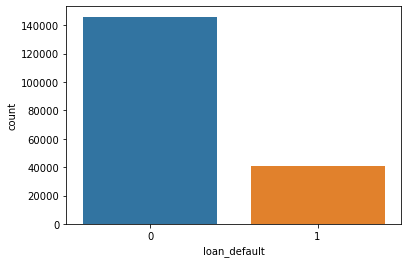

In [12]:
sns.countplot(x = "loan_default", data = df)

In [13]:
print("Répartition de la variable loan_default en pourcentage")
df["loan_default"].value_counts() / len(df)

Répartition de la variable loan_default en pourcentage


0   0.78
1   0.22
Name: loan_default, dtype: float64

In [14]:
mean_std_df2 = df_num_count.describe().loc[["mean", 'std']].transpose()
cv_df2 = (df_num_count.describe().loc["mean"]/df_num_count.describe().loc["std"]).transpose()

mean_std_df0 = df_num_count[df_num_count["loan_default"] == 0].describe().loc[["mean", 'std']].transpose().rename(columns = {'mean' : "mean0", 'std': "std0"})
cv_df0 = (df_num_count[df_num_count["loan_default"] == 0].describe().loc["mean"]/df_num_count[df_num_count["loan_default"] == 0].describe().loc["std"]).transpose()

mean_std_df1 = df_num_count[df_num_count["loan_default"] == 1].describe().loc[["mean", 'std']].transpose().rename(columns = {'mean' : "mean1", 'std': "std1"})
cv_df1 = (df_num_count[df_num_count["loan_default"] == 1].describe().loc["mean"]/df_num_count[df_num_count["loan_default"] == 1].describe().loc["std"]).transpose()

mean_type = pd.concat([mean_std_df2,cv_df2,mean_std_df0, cv_df0, mean_std_df1, cv_df1], axis = 1).rename(columns = {0 : "cv", 1 : 'cv0', 2 : "cv1"})
mean_type

,mean,std,cv,mean0,std0,cv0,mean1,std1,cv1
disbursed_amount,54360.39,12892.15,4.22,53823.27,13034.41,4.13,56297.88,12170.14,4.63
asset_cost,75852.97,18745.29,4.05,75708.30,18763.00,4.03,76374.81,18672.19,4.09
ltv,74.76,11.45,6.53,74.16,11.67,6.35,76.91,10.30,7.46
PERFORM_CNS_SCORE,289.36,338.30,0.86,299.83,342.81,0.87,251.61,318.67,0.79
PRI_CURRENT_BALANCE,167463.18,961157.44,0.17,181024.52,1013882.60,0.18,118544.56,738341.85,0.16
PRI_SANCTIONED_AMOUNT,221849.68,2602637.16,0.09,234946.91,1261215.72,0.19,174605.17,5046558.42,0.03
PRI_DISBURSED_AMOUNT,221501.80,2605899.72,0.09,234448.12,1268103.80,0.18,174801.66,5048095.00,0.03
SEC_CURRENT_BALANCE,5645.73,175271.16,0.03,6174.05,188749.22,0.03,3739.99,114095.39,0.03
SEC_SANCTIONED_AMOUNT,7522.19,187177.49,0.04,8157.32,198221.08,0.04,5231.15,140272.38,0.04
SEC_DISBURSED_AMOUNT,7408.84,186628.09,0.04,8029.85,197603.10,0.04,5168.70,140045.79,0.04


Les variables "discrètes" du type PRI_NO_ACCTS jusqu'à NO_OF_INQUIRIES_K varient peu, et sont même concentrées autour de la valeur zéro. Il est difficile avec d'établir un premier lien avec notre variable cible.
Pour ce qui est du reste de nos variables continues, celles qui sortent du lot vis-à-vis de notre variable cible sont les variables SANCTIONNED AMOUNT. 
En revanche, on peut voir qu'elle varient beaucoup, peu importe si les clients ont un défaut de paiement ou non.

La variable loan_default est déséquilibrée. À cela s'ajoute le fait que les observations de nos deux classes (loan_defaut = 0 ou 1) sont assez similaires.

Pour les variables discrètes, on peut le voir avec les différents histogrammes suivants : 

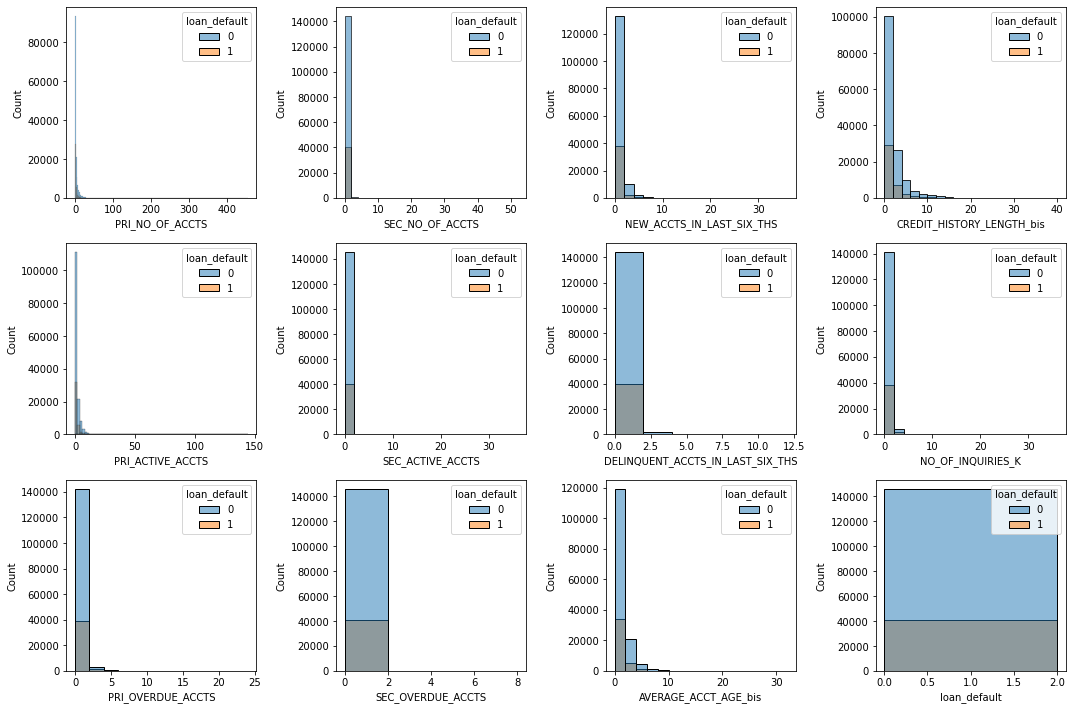

In [99]:
fig, ax = plt.subplots(ncols = 4, nrows = 3, figsize = (15,10))
i,j = 0,0
for col in df_count.columns : 
    sns.histplot(x = col, hue = "loan_default", data = df, ax = ax[j,i], binwidth=2)
    j += 1
    if j == 3 : 
        i,j = i+1, 0
fig.tight_layout()

In [90]:
#BOXPLOT TABLEAU
'''
Au vu du nombre de données, les calculs étaient trop longs pour faire des boxplots pour chaque variable.
Nous avons donc fait des tableaux qui contiennent : 
min, q1, pourcentage de valeur entre q1 et q3, q3, max
dans cet ordre 
'''

for i in [0,1,2] :
    inf_q1 = []
    betw_q1q3 = []
    sup_q3 = []
    listq1 = []
    listq3 = []
    for k in range(len(df.select_dtypes("number").columns)) : 
        if i != 2 :
            s_y = df[df["loan_default"] == i][df.select_dtypes("number").columns[k]]
            n_obs = len(df[df["loan_default"] == i])
        else : 
            s_y = df[df.select_dtypes("number").columns[k]]
            n_obs = len(df)
        
        q1 = np.quantile(s_y, 0.25)
        q3 = np.quantile(s_y, 0.75)
        inf = sum(s_y < q1)/n_obs
        bet = sum((q1 <= s_y) & (s_y <= q3))/n_obs
        sup = sum(s_y > q3)/n_obs
        mean_sy = np.mean(s_y)
        listq1.append(q1) 
        listq3.append(q3)
        inf_q1.append(inf)
        betw_q1q3.append(bet)
        sup_q3.append(sup)

    col = {
        "infq1" : np.array(inf_q1),
        "q1" : np.array(listq1),
        "betwq1q3" : np.array(betw_q1q3), 
        "q3" : np.array(listq3),
        "supq3" : np.array(sup_q3),
        'index' : np.array(df.select_dtypes("number").columns)
    }

    quantile_view = pd.DataFrame(col)
    quantile_view.set_index('index', inplace = True)
    if i == 0 : 
        print("----- Loan_default = 0 -------", "\n")
    elif i == 2 : 
        print("Data without loan_default filter", "\n")
    else : 
        print("----- Loan_default = 1 -------", "\n")
    print(quantile_view)
    print("\n")

----- Loan_default = 0 ------- 

                                  infq1       q1  betwq1q3       q3  supq3
index                                                                     
disbursed_amount                   0.25 46369.00      0.50 59947.00   0.25
asset_cost                         0.25 65667.00      0.50 78990.00   0.25
ltv                                0.25    68.03      0.50    83.16   0.25
PERFORM_CNS_SCORE                  0.00     0.00      0.75   690.00   0.25
PRI_NO_OF_ACCTS                    0.00     0.00      0.78     3.00   0.22
PRI_ACTIVE_ACCTS                   0.00     0.00      0.76     1.00   0.24
PRI_OVERDUE_ACCTS                  0.00     0.00      0.90     0.00   0.10
PRI_CURRENT_BALANCE                0.00     0.00      0.75 38586.00   0.25
PRI_SANCTIONED_AMOUNT              0.00     0.00      0.75 70000.00   0.25
PRI_DISBURSED_AMOUNT               0.00     0.00      0.75 67500.00   0.25
SEC_NO_OF_ACCTS                    0.00     0.00      0.97     0.00

Encore une fois, très peu de distinctions avec la variable cible. Mis à part les valeurs q1 et q3 qui changent pour les variables SANCTIONNED_AMOUNT et CURRENT_BALANCE.

### Test de correlation Pearson

In [91]:
from scipy.stats import pearsonr, spearmanr

Matrice de corrélation (Pearson)

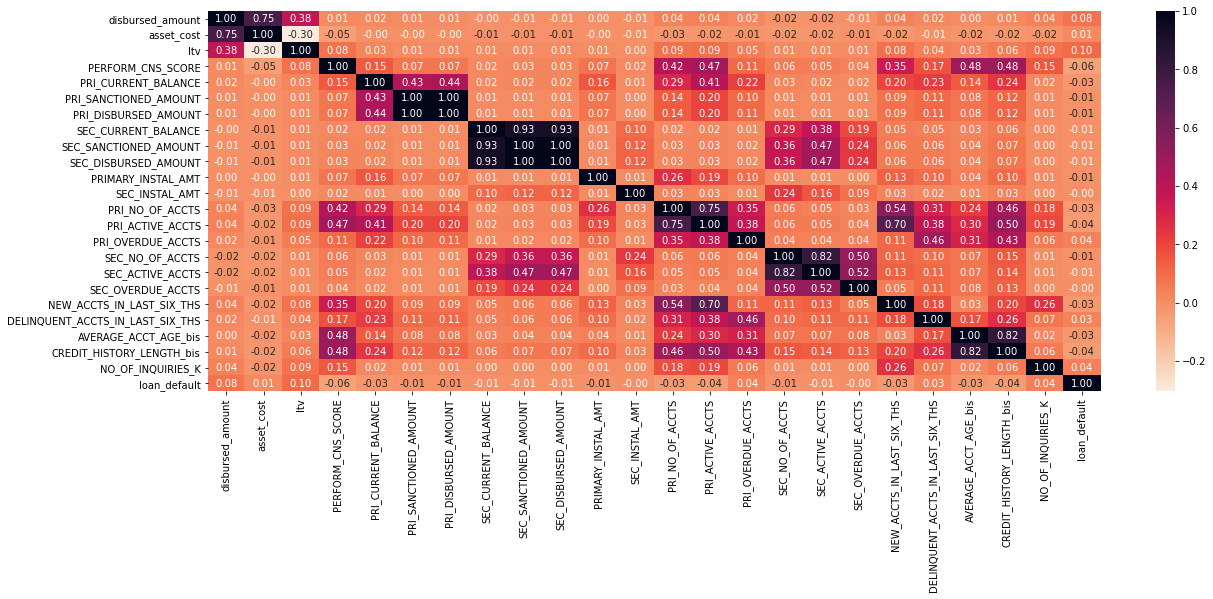

In [94]:
fig, ax = plt.subplots(figsize = (20,7))
sns.heatmap(df_num_count.corr("pearson"), annot=True, fmt='.2f' ,  cmap='rocket_r')
ax.xaxis.set_tick_params(rotation=90)

Test, matrice des p-values

<AxesSubplot:>

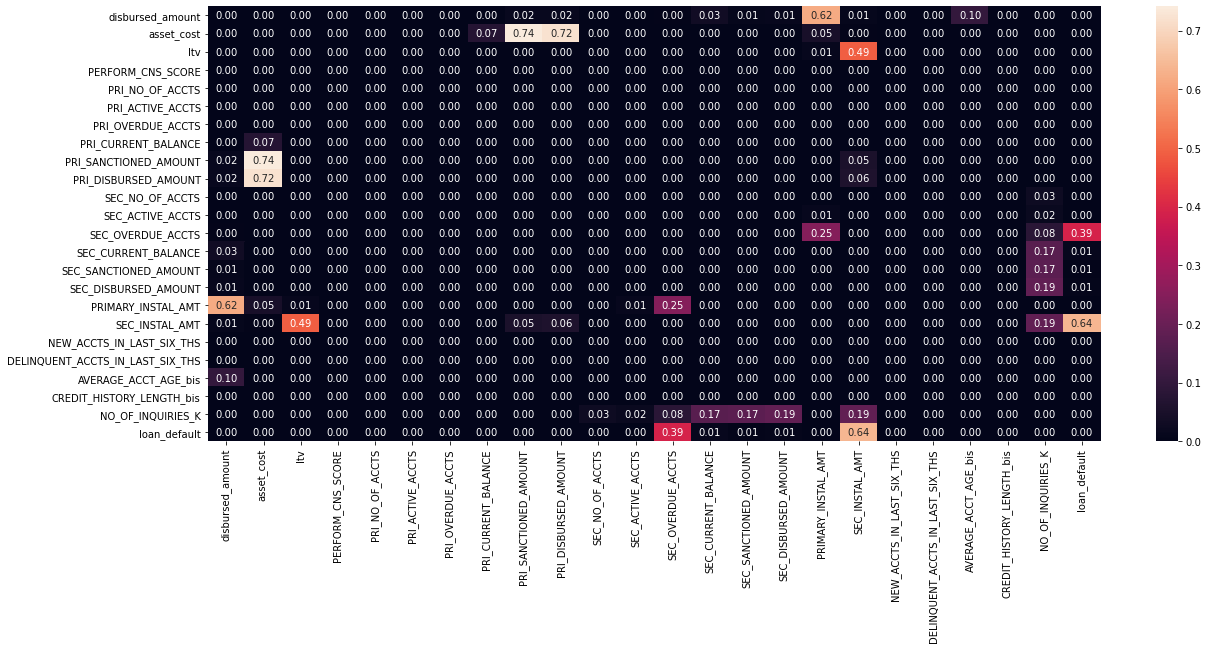

In [92]:
p_value = {}
for col1 in df.select_dtypes("number").columns : 
    p_val = []
    for col2 in df.select_dtypes("number").columns : 
        p_val.append(pearsonr(df[col1], df[col2])[1])
    p_value[col1] = np.array(p_val)
    
test_pearson = pd.DataFrame(p_value)
test_pearson.set_index(df.select_dtypes("number").columns, inplace=True)

plt.figure(figsize=(20,8))
sns.heatmap(test_pearson, annot=True, fmt='.002f')

### Test de corrélation de Spearman

Matrice de corrélation (Spearman)

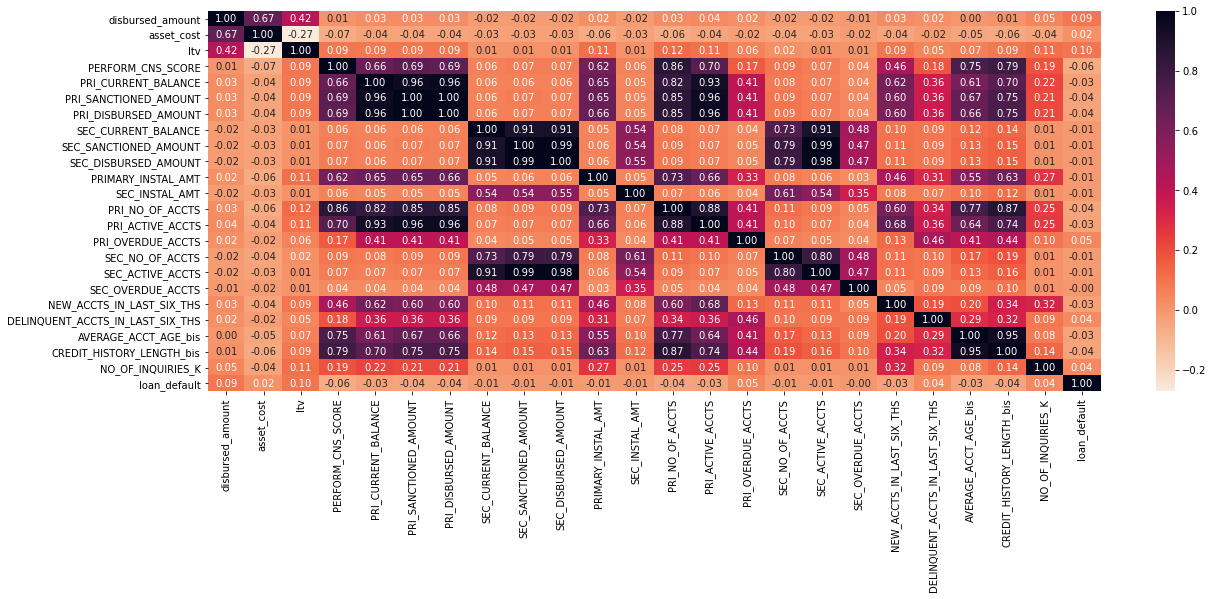

In [26]:
fig, ax = plt.subplots(figsize = (20,7))
sns.heatmap(df_num_count.corr("spearman"), annot=True, fmt='.2f' ,  cmap='rocket_r')
ax.xaxis.set_tick_params(rotation=90)

Test, matrice des p-values

<AxesSubplot:>

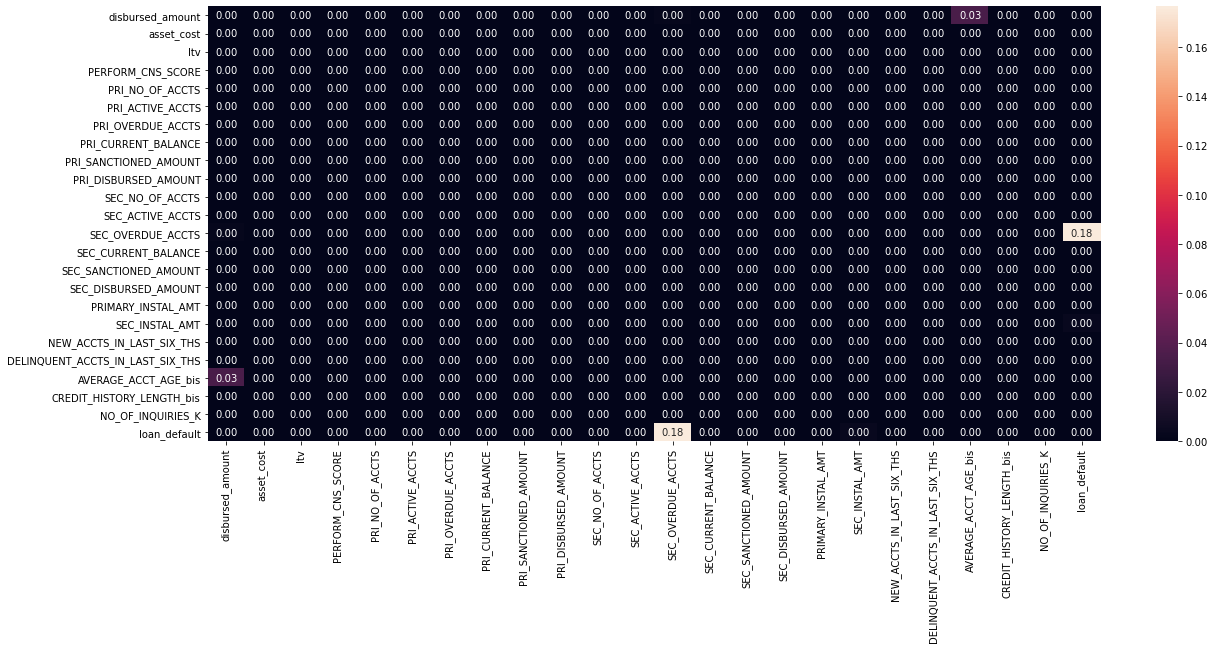

In [95]:
p_value = {}
for col1 in df.select_dtypes("number").columns : 
    p_val = []
    for col2 in df.select_dtypes("number").columns : 
        p_val.append(spearmanr(df[col1], df[col2])[1])
    p_value[col1] = np.array(p_val)
    
test_pearson = pd.DataFrame(p_value)
test_pearson.set_index(df.select_dtypes("number").columns, inplace=True)

plt.figure(figsize=(20,8))
sns.heatmap(test_pearson, annot=True, fmt='.002f')

Les matrices de corrélation et tests nous ont permis d'avoir un premier regard sur le lien entre chaque variable quantitative. Nous avons effectué une ACP sous R. Nous n'allons pas montrer l'ensemble des résultats pour ne pas faire grossir le notebook. 

Selon notre PCA, les 9 premiers axes expliquent 70% de la variance, ce qui fait un bon nombre de dimensions pour uniiquement 70% de variance. Nous pouvions le supposer en amont, au vu de la matrice de corrélation.

# Resultats ACP R

In [405]:
from IPython.display import Image

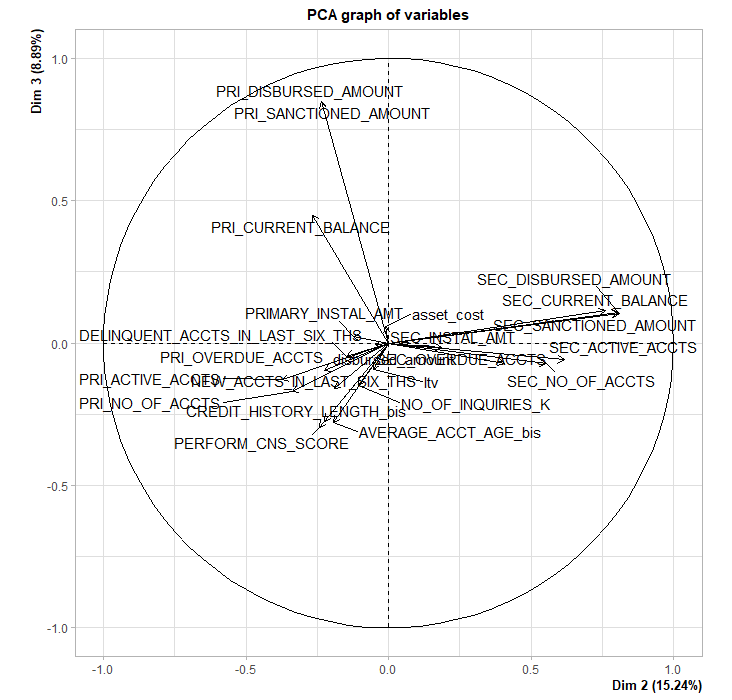

In [417]:
Image("Rplot.png")

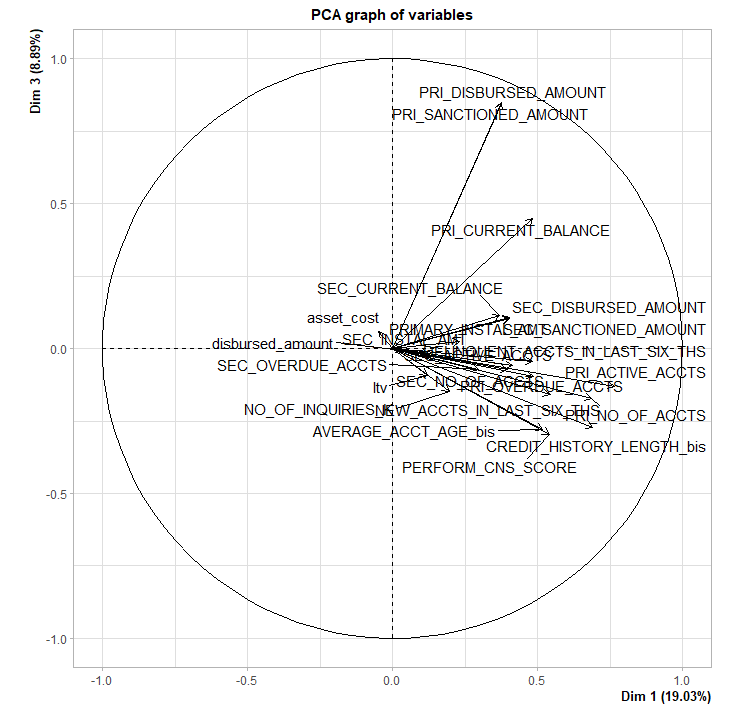

In [418]:
Image("Rplot01.png")

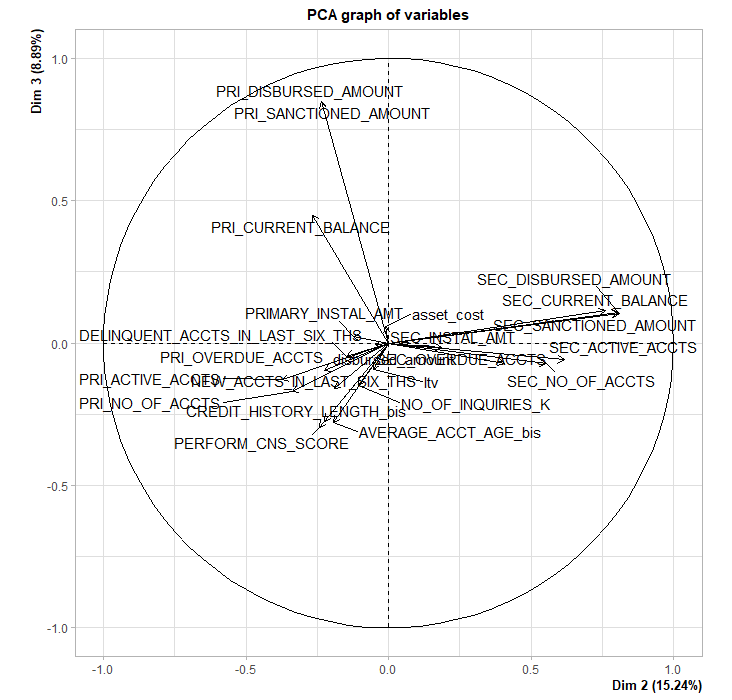

In [419]:
Image("Rplot02.png")

On peut voir sur les trois premiers axes factoriels, les variables qui ressortent le plus : 
* DIM 1 : PRI ACTIVE ACCTS, CREDIT HISTORY, PRI NO ACCT, NEWS ACCTS IN LAST SIX, PERFORM CNS SCORE
* DIM 2 : SANCTIONNED AMOUNT, SEC DISBURSED, SEC_CURRENT_BAL, SEC ACTIVE NO ACCTS
* DIM 3 : DISBURSED_AMOUNT, PRI SANCTIONNED AMOUNT

Les dimensions 4 et 5 nous donnent : 

* DIM 4 : DISBURSED, ASSET COST
* DIM 5 : SEC NO OF ACCT, SEC OVERDUE, SEC ACTIVE ACC, SEC CURRENT BALANCE, SEC DISBURSED


### Test d'ANOVA par rapport à la variable cible

Nous avons effectué un test d'analyse de variance entre nos variables numériques et la variable cible afin de voir s'il existe un lien de dépendance ou non entre celles-ci.

In [118]:
anova_test = pd.DataFrame(f_classif(df.select_dtypes("number"), df["loan_default"])).transpose().set_index(df.select_dtypes("number").columns).rename(columns = {0 : "F-statistic", 1 : "p-value"})
anova_test = anova_test.sort_values(by = "F-statistic", ascending = False)
anova_test

C:\Users\Znbdy\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,F-statistic,p-value
loan_default,inf,0.00
ltv,1846.60,0.00
disbursed_amount,1175.21,0.00
PERFORM_CNS_SCORE,646.12,0.00
NO_OF_INQUIRIES_K,366.62,0.00
CREDIT_HISTORY_LENGTH_bis,347.48,0.00
PRI_ACTIVE_ACCTS,319.45,0.00
PRI_OVERDUE_ACCTS,309.10,0.00
PRI_NO_OF_ACCTS,217.59,0.00
DELINQUENT_ACCTS_IN_LAST_SIX_THS,204.33,0.00


Avec toute notre analyse, nous avons décidé de sélectionner les variables suivantes dans notre modèle :

# Choix des features

- ltv 
- disbursed_amount
- PRI_SANCTIONED_AMOUNT
- DELINQUENT_ACCTS_IN_LAST_SIX_THS
- SEC_SANCTIONED_AMOUNT

Bien que corrélées, nous avons choisi ltv et disbursed amount car entre avoir le rapport montant avoir/montant prêt uniquement et le rapport ltv + montant demandé pour le crédit, il y a une différence. 
Sans prendre en compte le revenu de l'individu, emprunter 1 millions pour un ltv à 20% et emprunter 4000 euros pour le même ltv n'a pas le même enjeu. 

In [15]:
features = ["ltv" , "disbursed_amount","PRI_SANCTIONED_AMOUNT","DELINQUENT_ACCTS_IN_LAST_SIX_THS", "SEC_SANCTIONED_AMOUNT"]
X_train, y_train = df[features], df["loan_default"]
X_test, y_test = df_test[features], df_test["loan_default"]

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

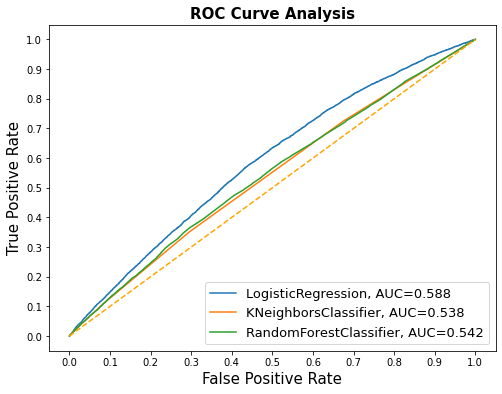

In [17]:
classifiers = [LogisticRegression(), 
               KNeighborsClassifier(), 
               RandomForestClassifier()]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = make_pipeline(StandardScaler(), cls)
    model.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### DISCRETISATION DES Variables

In [21]:
def woe_iv(data, var, target) :
    event = data[data[target] == 1][var].value_counts() / len(data[data[target] == 1])
    no_event = data[data[target] == 0][var].value_counts() / len(data[data[target] == 0])
    woe = np.array(np.log(event/no_event))
    iv = np.array(sum(event - no_event) * woe)
    df_woe_col = { "woe" : woe,  "iv" : iv}
    df_woe = pd.DataFrame(df_woe_col)
    return(df_woe)

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

Discrétisons de façon uniforme

In [24]:
KBINdis = KBinsDiscretizer(n_bins = 10,encode = "ordinal" , strategy = "uniform")
X_train_dis = KBINdis.fit_transform(X_train)
X_train_dis = pd.DataFrame(X_train_dis)
X_train_dis.columns = X_train.columns
df_discr = pd.concat([X_train_dis, y_train], axis = 1)
for col in X_train.columns :
    print("---", col, "---")
    print(woe_iv(data = df_discr, var = col, target = "loan_default"))

--- ltv ---
    woe    iv
0 -0.00  0.00
1 -0.02  0.00
2 -0.01  0.00
3 -0.04  0.00
4  0.01 -0.00
5 -0.03  0.00
6 -0.01  0.00
7 -0.21  0.00
8  0.09 -0.00
9 -1.11  0.01
--- disbursed_amount ---
    woe  iv
0 -0.01 nan
1 -0.01 nan
2   nan nan
3   nan nan
--- PRI_SANCTIONED_AMOUNT ---
    woe  iv
0 -0.01 nan
1   nan nan
--- DELINQUENT_ACCTS_IN_LAST_SIX_THS ---
    woe    iv
0 -0.01  0.00
1  0.09 -0.00
2  0.02 -0.00
3  0.11 -0.00
4  0.30 -0.00
5  0.72 -0.01
6 -0.10  0.00
7  0.59 -0.01
--- SEC_SANCTIONED_AMOUNT ---
    woe  iv
0 -0.01 nan
1  0.31 nan
2  0.59 nan
3  0.59 nan
4   nan nan
5   nan nan
6   nan nan
7   nan nan


Difficile de faire une première interprètation sur le WOE et IV. On voit qu'il y a des WOE communs pour certaines variables mais pas pour le reste. De plus, au vu de comment se comportent ces variables par rapport à la variable cible, la question de la discrétisation porte son doute, surtout avec des iv à zéro voire incalculables (SEC Sanctionned ammount). Essayons plutôt de discrétiser par rapport aux quantiles.

In [28]:
KBINdis = KBinsDiscretizer(n_bins = 10,encode = "ordinal" , strategy = "quantile")
X_train_dis = KBINdis.fit_transform(X_train)
X_train_dis = pd.DataFrame(X_train_dis)
X_train_dis.columns = X_train.columns
df_discr = pd.concat([X_train_dis, y_train], axis = 1)
for col in X_train.columns :
    print("---", col, "---")
    print(woe_iv(data = df_discr, var = col, target = "loan_default"))

C:\Users\Znbdy\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Znbdy\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\Znbdy\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


--- ltv ---
    woe    iv
0 -0.01  0.00
1 -0.01  0.00
2 -0.02  0.00
3 -0.03  0.00
4 -0.00  0.00
5  0.00 -0.00
6 -0.02  0.00
7 -0.02  0.00
8  0.03 -0.00
9 -0.05  0.00
--- disbursed_amount ---
    woe    iv
0 -0.01  0.00
1 -0.02  0.00
2  0.02 -0.00
3 -0.02  0.00
4  0.01 -0.00
5 -0.02  0.00
6 -0.02  0.00
7 -0.03  0.00
8 -0.05  0.00
9 -0.00  0.00
--- PRI_SANCTIONED_AMOUNT ---
    woe    iv
0 -0.01  0.00
1 -0.01  0.00
2 -0.04  0.00
3  0.01 -0.00
4 -0.02  0.00
--- DELINQUENT_ACCTS_IN_LAST_SIX_THS ---
    woe   iv
0 -0.01 0.00
--- SEC_SANCTIONED_AMOUNT ---
    woe   iv
0 -0.01 0.00


Même conclusion

### Une solution alternative : le resampling ?

Le resampling est une méthode qui consiste à rajouter des éléments fictifs dans le set d'entrainement. Cela a pour but de réequilibrer les observations selon la variable cible. Cependant, on a un risque de biais dans notre jeu de données.

In [30]:
from imblearn.over_sampling import SMOTE

In [23]:
sm = SMOTE()
X_train2, y_train2 = sm.fit_resample(X_train, y_train)

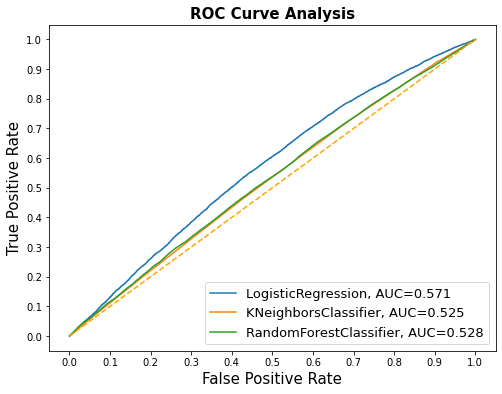

In [26]:
classifiers = [LogisticRegression(), 
               KNeighborsClassifier(), 
               RandomForestClassifier()]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = make_pipeline(StandardScaler(), cls)
    model.fit(X_train2, y_train2)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### Ajoutons des features 

In [62]:
features = ["ltv" ,"disbursed_amount","PRI_CURRENT_BALANCE" ,"PRI_DISBURSED_AMOUNT" ,"SEC_CURRENT_BALANCE" ,"PRI_NO_OF_ACCTS" ,"PRI_OVERDUE_ACCTS" ,"DELINQUENT_ACCTS_IN_LAST_SIX_THS" ,"NEW_ACCTS_IN_LAST_SIX_THS"]

In [63]:
X_train3, y_train3 = df[features], df["loan_default"]
X_test3, y_test3 = df_test[features], df_test["loan_default"]

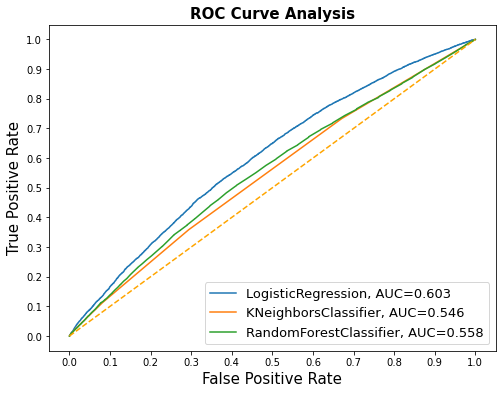

In [72]:
classifiers = [LogisticRegression(), 
               KNeighborsClassifier(), 
               RandomForestClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = make_pipeline(StandardScaler(), cls)
    model.fit(X_train3, y_train3)
    yproba = model.predict_proba(X_test3)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test3,  yproba)
    auc = roc_auc_score(y_test3, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Conclusion 

Notre approche ne semble pas être concluante, obtenir un AUC à 0.6 n'est pas suffisant. Cela provient-il de la qualité de la base ? Un mauvais choix de features malgré étude ? De plus, le modèle n'est pas complet, il faut encore parler de l'interprétabilité du modèle, qui est une autre approche (de plus en plus demandée). Enfin et dernière question que soulève notre approche, si le nombre de features était plus grand, serions-nous passé par une exploration statistiques comme faîtes précédement ? 